# Data Dictionary

For this Datasets, are columns are defined here, this is taken from a Data Article talking about the contents which can be found on Kaggle

https://www.sciencedirect.com/science/article/pii/S2352340918315191

https://www.kaggle.com/datasets/jessemostipak/hotel-booking-demand

hotel - Type of hotel, classified as Resort Hotel or City Hotel

is_canceled - Value indicating if the booking was canceled (1) or not (0)

lead_time - Number of days that elapsed between date of booking and the arrival date

arrival_date_year - Year of arrival date

arrival_date_month - Month of arrival date

arrival_date_week_number - Week number of year for arrival date

arrival_date_day_of_month - Day of arrival date

stays_in_weekend_nights - Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel

stays_in_week_nights - Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel

adults - Number of adults

children - Number of children

babies - Number of babies

meal - Type of meal booked. Categories are presented in standard hospitality meal packages: Undefined/SC – no meal package;
BB – Bed & Breakfast;
HB – Half board (breakfast and one other meal – usually dinner);
FB – Full board (breakfast, lunch and dinner)

country - Country of origin. Categories are represented in the ISO 3155–3:2013 format

market_segment - Market segment designation. In categories, the term “TA” means “Travel Agents” and “TO” means “Tour"

distribution_channel - Booking distribution channel. The term “TA” means “Travel Agents” and “TO” means “Tour Operators”

is_repeated_guest - Value indicating if the booking name was from a repeated guest (1) or not (0)

previous_cancellations - Number of previous bookings that were cancelled by the customer prior to the current booking

previous_bookings_not_canceled - Number of previous bookings not cancelled by the customer prior to the current booking

reserved_room_type - Code of room type reserved. Code is presented instead of designation for anonymity reasons.

assigned_room_type - Code for the type of room assigned to the booking

booking_changes - Number of changes/amendments made to the booking from the moment the booking was entered on

deposit_type - Indication on if the customer made a deposit to guarantee the booking.

agent - ID of the travel agency that made the booking

company - ID of the company/entity that made the booking or responsible for paying the booking.

days_in_waiting_list - Number of days the booking was in the waiting list before it was confirmed to the customer

customer_type - Type of booking

adr - Average Daily Rate as defined by dividing the sum of all lodging transactions by the total number of staying nights

required_car_parking_spaces - Number of car parking spaces required by the customer

total_of_special_requests - Number of special requests made by the customer (e.g. twin bed or high floor)

reservation_status - Reservation last status

reservation_status_date - Date at which the last status was set

# Intention

The goal of using this data set will be to explore various machine learning models. Utilizing different models to explore time series analysis as well as neural networks to predict the price of hotel bookings.

The price of the booking is not explicitly stated anywhere in the dataset, however the average daily rate(adr) can be used to calculate the price of the booking, we realize that this data is not truly accurate however will give us a good estimate of the booking prices.

In [117]:
!pip install dmba
!pip install pmdarima
!pip install prophet

  Using cached holidays-0.70-py3-none-any.whl.metadata (34 kB)
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/13.3 MB 62.2 kB/s eta 0:03:34
   ---------------------------------------- 0.0/13.3 MB 81.9 kB/s eta 0:02:43
   ---------------------------------------- 0.1/13.3 MB 242.7 kB/s eta 0:00:55
   ---------------------------------------- 0.1/13.3 MB 242.7 kB/s eta 0:00:55
   ---------------------------------------- 0.1/13.3 MB 242.7 k

# Preliminary data exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from statistics import mean
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping
from scipy.stats import yeojohnson
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load data
df = pd.read_csv('hotel_bookings.csv')

# Gets the shape of the data
print(df.shape)

df #show all the data

(119390, 32)


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.00,0,1,Check-Out,2015-07-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,...,No Deposit,394.0,NaN,0,Transient,96.14,0,0,Check-Out,2017-09-06
119386,City Hotel,0,102,2017,August,35,31,2,5,3,...,No Deposit,9.0,NaN,0,Transient,225.43,0,2,Check-Out,2017-09-07
119387,City Hotel,0,34,2017,August,35,31,2,5,2,...,No Deposit,9.0,NaN,0,Transient,157.71,0,4,Check-Out,2017-09-07
119388,City Hotel,0,109,2017,August,35,31,2,5,2,...,No Deposit,89.0,NaN,0,Transient,104.40,0,0,Check-Out,2017-09-07


This is a very large dataset, of 119390 rows and 32 columns, we will be exploring the data to make sense of the dataset as well as seeing what can be can be of use or what can be manipulated into usable data, as well as determining columns which can be eliminated due to lack of interpretable information.

In [4]:
df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

In [5]:
# Checking the data type of each column
data_types = df.dtypes
data_types

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             

In [6]:
# Counts the number of entries where value is null for each row

missing_data = df.isnull().sum()
# Shows each column and how many missing values there are
missing_data

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [7]:
# Fill missing values in 'children' with the median
df['children'] = df['children'].fillna(df['children'].median())

# Fill missing values in 'country' with the most frequent value
df['country'] = df['country'].fillna(df['country'].mode()[0])

Country and Children have very small portions of their data missing. For those we will be taking the mode and median respectively for the data.

However, there is a significant portion of the dataset that is missing in C
Company, as well as Agent, let's look into the dataset

In [9]:
df[['agent', 'company']]

,agent,company
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,304.0,NaN
4,240.0,NaN
...,...,...
119385,394.0,NaN
119386,9.0,NaN
119387,9.0,NaN
119388,89.0,NaN


Looking at the dataset, the all the values are placed in a system where the booking agent ID is registered, however there is no information that goes along with this that would help us identify what company or agency has been used for booking. We will however not be removing them, as we believe the null values are a placeholder for no registration with a agent or company.

We will transform these into binary columns where the null values will be placed with 0 (not booked with an agent or company), and a 1 where the data is not null.

In [11]:
# Creates a True or False in the data for whether it is not null
df['agent'] = df['agent'].notna().astype(int)
df['company'] = df['company'].notna().astype(int)
df = df.dropna()

In [12]:
# Viewing columns again
df[['agent', 'company']]

,agent,company
0,0,0
1,0,0
2,0,0
3,1,0
4,1,0
...,...,...
119385,1,0
119386,1,0
119387,1,0
119388,1,0


In [13]:
# Getting the shape, result shows nothing else was removed
df.shape

(119390, 32)

# Data Preprocessing and Feature Engineering
Due to the size of the dataset, we will be looking at the columns in sections

In this section we will also be creating dummy variables, so before doing so we want to check if the dummy variables are too high

In [15]:
unique_values = df.nunique()

# Print the result
print(unique_values)

hotel                                2
is_canceled                          2
lead_time                          479
arrival_date_year                    3
arrival_date_month                  12
arrival_date_week_number            53
arrival_date_day_of_month           31
stays_in_weekend_nights             17
stays_in_week_nights                35
adults                              14
children                             5
babies                               5
meal                                 5
country                            177
market_segment                       8
distribution_channel                 5
is_repeated_guest                    2
previous_cancellations              15
previous_bookings_not_canceled      73
reserved_room_type                  10
assigned_room_type                  12
booking_changes                     21
deposit_type                         3
agent                                2
company                              2
days_in_waiting_list     

In [16]:
unique_values_count = df.nunique()

# Print the result
print(unique_values_count)

hotel                                2
is_canceled                          2
lead_time                          479
arrival_date_year                    3
arrival_date_month                  12
arrival_date_week_number            53
arrival_date_day_of_month           31
stays_in_weekend_nights             17
stays_in_week_nights                35
adults                              14
children                             5
babies                               5
meal                                 5
country                            177
market_segment                       8
distribution_channel                 5
is_repeated_guest                    2
previous_cancellations              15
previous_bookings_not_canceled      73
reserved_room_type                  10
assigned_room_type                  12
booking_changes                     21
deposit_type                         3
agent                                2
company                              2
days_in_waiting_list     

In [17]:
#First 10 columns
col1_10 = df.iloc[:, :10]
col1_10

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults
0,Resort Hotel,0,342,2015,July,27,1,0,0,2
1,Resort Hotel,0,737,2015,July,27,1,0,0,2
2,Resort Hotel,0,7,2015,July,27,1,0,1,1
3,Resort Hotel,0,13,2015,July,27,1,0,1,1
4,Resort Hotel,0,14,2015,July,27,1,0,2,2
...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2
119386,City Hotel,0,102,2017,August,35,31,2,5,3
119387,City Hotel,0,34,2017,August,35,31,2,5,2
119388,City Hotel,0,109,2017,August,35,31,2,5,2


Hotel must be changed into a numeric indication, we will encode resort as 0, and city hotel as 1

In [29]:
df['hotel'] = pd.to_numeric(df['hotel'].replace({'Resort Hotel': 0, 'City Hotel': 1}))

We have columns corresponding to the time of year the booking is in, we will drop the arrival_date_week_number as that information can be interpreted from the date.

The month will be changed into a numeric format for use in our models

In [35]:
# Changes the months into numbers and converts from string to numeric datatype
df['arrival_date_month'] = df['arrival_date_month'].replace({
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4,
    'May': 5,
    'June': 6,
    'July': 7,
    'August': 8,
    'September': 9,
    'October': 10,
    'November': 11,
    'December': 12}).astype(int)

In [37]:
# Checking if all months are present and conversion has worked.
df['arrival_date_month'].unique()

array([ 7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6])

In [39]:
#10 - 20 columns
col11_21 = df.iloc[:, 10:21]
col11_21

,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type
0,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C
1,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C
2,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C
3,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A
4,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A
...,...,...,...,...,...,...,...,...,...,...,...
119385,0.0,0,BB,BEL,Offline TA/TO,TA/TO,0,0,0,A,A
119386,0.0,0,BB,FRA,Online TA,TA/TO,0,0,0,E,E
119387,0.0,0,BB,DEU,Online TA,TA/TO,0,0,0,D,D
119388,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A


Reserved room type and assigned room type are not applicable as it has been replaced with a symbol to preserve anonymity, will drop the column at the end as we are still analyzing the columns

meal, country, market_segment, distribution channel are all interpretable in some way with multiple categories, will one hot encode them into dummy variables.

We noticed from earlier that country has a significant list of unique values, 177 to be exact... we will attempt to group these values into continents to make the list smaller.

In [42]:
df['country'].unique()

array(['PRT', 'GBR', 'USA', 'ESP', 'IRL', 'FRA', 'ROU', 'NOR', 'OMN',
       'ARG', 'POL', 'DEU', 'BEL', 'CHE', 'CN', 'GRC', 'ITA', 'NLD',
       'DNK', 'RUS', 'SWE', 'AUS', 'EST', 'CZE', 'BRA', 'FIN', 'MOZ',
       'BWA', 'LUX', 'SVN', 'ALB', 'IND', 'CHN', 'MEX', 'MAR', 'UKR',
       'SMR', 'LVA', 'PRI', 'SRB', 'CHL', 'AUT', 'BLR', 'LTU', 'TUR',
       'ZAF', 'AGO', 'ISR', 'CYM', 'ZMB', 'CPV', 'ZWE', 'DZA', 'KOR',
       'CRI', 'HUN', 'ARE', 'TUN', 'JAM', 'HRV', 'HKG', 'IRN', 'GEO',
       'AND', 'GIB', 'URY', 'JEY', 'CAF', 'CYP', 'COL', 'GGY', 'KWT',
       'NGA', 'MDV', 'VEN', 'SVK', 'FJI', 'KAZ', 'PAK', 'IDN', 'LBN',
       'PHL', 'SEN', 'SYC', 'AZE', 'BHR', 'NZL', 'THA', 'DOM', 'MKD',
       'MYS', 'ARM', 'JPN', 'LKA', 'CUB', 'CMR', 'BIH', 'MUS', 'COM',
       'SUR', 'UGA', 'BGR', 'CIV', 'JOR', 'SYR', 'SGP', 'BDI', 'SAU',
       'VNM', 'PLW', 'QAT', 'EGY', 'PER', 'MLT', 'MWI', 'ECU', 'MDG',
       'ISL', 'UZB', 'NPL', 'BHS', 'MAC', 'TGO', 'TWN', 'DJI', 'STP',
       'KNA', 'ETH', 

In [44]:
def map_continent(country):
    if country in ['MOZ', 'BWA', 'ZMB', 'CPV', 'ZWE', 'DZA', 'ZAF', 'AGO', 'SEN', 'SYC', 'CIV', 'BDI', 'SEN', 'SYR', 'UGA', 'SYC', 'CIV',
                   'GAB', 'GHA', 'KEN', 'GNB', 'MUS', 'CMR', 'UGA', 'SEN', 'SDN', 'LBY', 'MLI', 'NAM', 'TZA', 'BEN', 'BFA', 'GAB', 'STP', 'MRT']:
        return 'Africa'
    elif country in ['OMN', 'CN', 'IND', 'CHN', 'KOR', 'ARE', 'ISR', 'KWT', 'MDV', 'IRN', 'GEO', 'KAZ', 'PAK', 'IDN', 'LBN', 'PHL', 'AZE', 'BHR',
                     'JPN', 'ARM', 'LKA', 'KAZ', 'VNM', 'QAT', 'EGY', 'BHR', 'SYR', 'HKG', 'THA', 'KHM', 'TWN', 'DJI', 'IRQ', 'HND', 'RWA', 'KHM',
                     'KIR', 'PAN', 'MMR', 'BHR', 'TJK']:
        return 'Asia'
    elif country in ['USA', 'MEX', 'CAN', 'CRI', 'HND', 'NIC', 'SLV', 'GTM', 'PAN', 'DOM', 'NIC', 'HND', 'HND', 'MEX', 'SLV', 'HND',
                     'MEX', 'NIC', 'GTM']:
        return 'North America'
    elif country in ['ARG', 'BRA', 'COL', 'CHL', 'URY', 'VEN', 'PER', 'ECU', 'SUR', 'BOL', 'PRY', 'GUY']:
        return 'South America'
    elif country in ['PRT', 'GBR', 'ESP', 'IRL', 'FRA', 'ROU', 'NOR', 'ARG', 'POL', 'DEU', 'BEL', 'CHE', 'GRC', 'ITA', 'NLD', 'DNK', 'RUS', 'SWE',
                     'EST', 'CZE', 'FIN', 'LUX', 'SVN', 'ALB', 'SMR', 'LVA', 'PRI', 'SRB', 'CHL', 'AUT', 'BLR', 'LTU', 'TUR', 'LUX', 'HRV', 'SVN',
                     'BLR', 'GIB', 'NLD', 'TUR', 'BLR', 'HRV', 'MNE', 'ISL', 'SWE', 'VGB', 'MNE', 'SVK', 'HRV', 'BGR', 'SVK', 'SRB']:
        return 'Europe'
    elif country in ['AUS', 'FJI', 'NZL', 'PLW', 'FJI', 'KIR', 'ATA', 'NCL', 'ASM', 'PYF', 'UMI', 'STP', 'MYT', 'KIR', 'MMR', 'FRO', 'TGO']:
        return 'Australia'
    else:
        return 'Other'

# run the function to the 'country' column
df['continent'] = df['country'].apply(map_continent)

In [46]:
# Print counts of each unique valuea
print(df['continent'].value_counts)

<bound method IndexOpsMixin.value_counts of 0         Europe
1         Europe
2         Europe
3         Europe
4         Europe
           ...  
119385    Europe
119386    Europe
119387    Europe
119388    Europe
119389    Europe
Name: continent, Length: 119390, dtype: object>


now creating the dummies for the columns mentioned previously as well as the column now named continent

In [49]:
dv_meal = pd.get_dummies(df['meal'], prefix='meal')

dv_continent = pd.get_dummies(df['country'].apply(map_continent), prefix='continent')

dv_market_segment = pd.get_dummies(df['market_segment'], prefix='market_segment')

dv_distribution_channel = pd.get_dummies(df['distribution_channel'], prefix='distribution_channel')

# Create a table containing the dummy variables, will append them to original df later
df_dummies = pd.concat([dv_meal, dv_continent, dv_market_segment, dv_distribution_channel], axis=1)
# Will drop the original columns after exploring the last 12

In [51]:
#22-32 columns
col22_32 = df.iloc[:, 21:32]
col22_32

,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,3,No Deposit,0,0,0,Transient,0.00,0,0,Check-Out,2015-07-01
1,4,No Deposit,0,0,0,Transient,0.00,0,0,Check-Out,2015-07-01
2,0,No Deposit,0,0,0,Transient,75.00,0,0,Check-Out,2015-07-02
3,0,No Deposit,1,0,0,Transient,75.00,0,0,Check-Out,2015-07-02
4,0,No Deposit,1,0,0,Transient,98.00,0,1,Check-Out,2015-07-03
...,...,...,...,...,...,...,...,...,...,...,...
119385,0,No Deposit,1,0,0,Transient,96.14,0,0,Check-Out,2017-09-06
119386,0,No Deposit,1,0,0,Transient,225.43,0,2,Check-Out,2017-09-07
119387,0,No Deposit,1,0,0,Transient,157.71,0,4,Check-Out,2017-09-07
119388,0,No Deposit,1,0,0,Transient,104.40,0,0,Check-Out,2017-09-07


In [53]:
# checking categories
print(df['deposit_type'].unique())
print(df['customer_type'].unique())
print(df['reservation_status'].unique())

['No Deposit' 'Refundable' 'Non Refund']
['Transient' 'Contract' 'Transient-Party' 'Group']
['Check-Out' 'Canceled' 'No-Show']


In [55]:
dv_deposit = pd.get_dummies(df['deposit_type'], prefix='deposit_type')
dv_customer = pd.get_dummies(df['customer_type'], prefix='customer_type')

# Appending more data onto the df_dummies table
df_dummies = pd.concat([df_dummies, dv_deposit, dv_customer], axis=1)

The reservation_status column can be simplified as the cancellation status which we have at the beginning of the table, will be dropping this as well as reservation_status_date

Below we are dropping all columns in the original dataset which either dummy variables were made for, or were not necessary for our analysis.

In [58]:
#Columns to be drop
df = df.drop(columns=['meal', 'continent', 'country', 'market_segment', 'distribution_channel', 'deposit_type', 'customer_type', 'reserved_room_type', 'assigned_room_type', 'reservation_status', 'reservation_status_date'])

# Removes any null values which may have occured from the data configurations
df = df.dropna()


In [60]:
df

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
0,0,0,342,2015,7,27,1,0,0,2,...,0,0,0,3,0,0,0,0.00,0,0
1,0,0,737,2015,7,27,1,0,0,2,...,0,0,0,4,0,0,0,0.00,0,0
2,0,0,7,2015,7,27,1,0,1,1,...,0,0,0,0,0,0,0,75.00,0,0
3,0,0,13,2015,7,27,1,0,1,1,...,0,0,0,0,1,0,0,75.00,0,0
4,0,0,14,2015,7,27,1,0,2,2,...,0,0,0,0,1,0,0,98.00,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,1,0,23,2017,8,35,30,2,5,2,...,0,0,0,0,1,0,0,96.14,0,0
119386,1,0,102,2017,8,35,31,2,5,3,...,0,0,0,0,1,0,0,225.43,0,2
119387,1,0,34,2017,8,35,31,2,5,2,...,0,0,0,0,1,0,0,157.71,0,4
119388,1,0,109,2017,8,35,31,2,5,2,...,0,0,0,0,1,0,0,104.40,0,0


We are almost done feature engineering our dataset and then moving on to feature selection

For the price prediction, we must make a new column that is the ADR multiplied by the stay in days, stay in days will also be formed as it is a good metric to have


In [63]:
# Create column that sums stay
df['stay_duration'] = df['stays_in_weekend_nights'] + df['stays_in_week_nights']

#creates column that calculates price of the booking

df['booking_price'] = df['adr'] * df['stay_duration']

# drops adr column as it was used to calculate price
df = df.drop(columns=['adr'])

In [65]:
# view column names
list(df.columns)

['hotel',
 'is_canceled',
 'lead_time',
 'arrival_date_year',
 'arrival_date_month',
 'arrival_date_week_number',
 'arrival_date_day_of_month',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'agent',
 'company',
 'days_in_waiting_list',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'stay_duration',
 'booking_price']

In [67]:
list(df_dummies.columns)

['meal_BB',
 'meal_FB',
 'meal_HB',
 'meal_SC',
 'meal_Undefined',
 'continent_Africa',
 'continent_Asia',
 'continent_Australia',
 'continent_Europe',
 'continent_North America',
 'continent_Other',
 'continent_South America',
 'market_segment_Aviation',
 'market_segment_Complementary',
 'market_segment_Corporate',
 'market_segment_Direct',
 'market_segment_Groups',
 'market_segment_Offline TA/TO',
 'market_segment_Online TA',
 'market_segment_Undefined',
 'distribution_channel_Corporate',
 'distribution_channel_Direct',
 'distribution_channel_GDS',
 'distribution_channel_TA/TO',
 'distribution_channel_Undefined',
 'deposit_type_No Deposit',
 'deposit_type_Non Refund',
 'deposit_type_Refundable',
 'customer_type_Contract',
 'customer_type_Group',
 'customer_type_Transient',
 'customer_type_Transient-Party']

In [69]:
#Appending the dummy variables for the dataset
df = pd.concat([df, df_dummies], axis=1)

now that the data has been manipulated, we will be looking at all the numerical data (excluding date based columns) and check for columns with a significant amount of outliers in the data using boxplots

Visually we can determine that some columns have most of the data outside of their interquartile range, which would heavily affect the impact on our model performance. In addition, it would be difficult to remove the existing rows as removing the majority of data would significantly reduce the data size.

However it is important to also note that our dataset will be used for determining cancellations alongside price predictions, which would make it very hard to justify removing some outliers as there is potential reason to keep outliers in the dataset if they are a reason for contribution to the cancellations.

For example, the number of people in a booking can go up to 50, however this may hold valuable information regarding special kinds of booking that could be of use to predicting cancellations, therefore we will be keeping them.

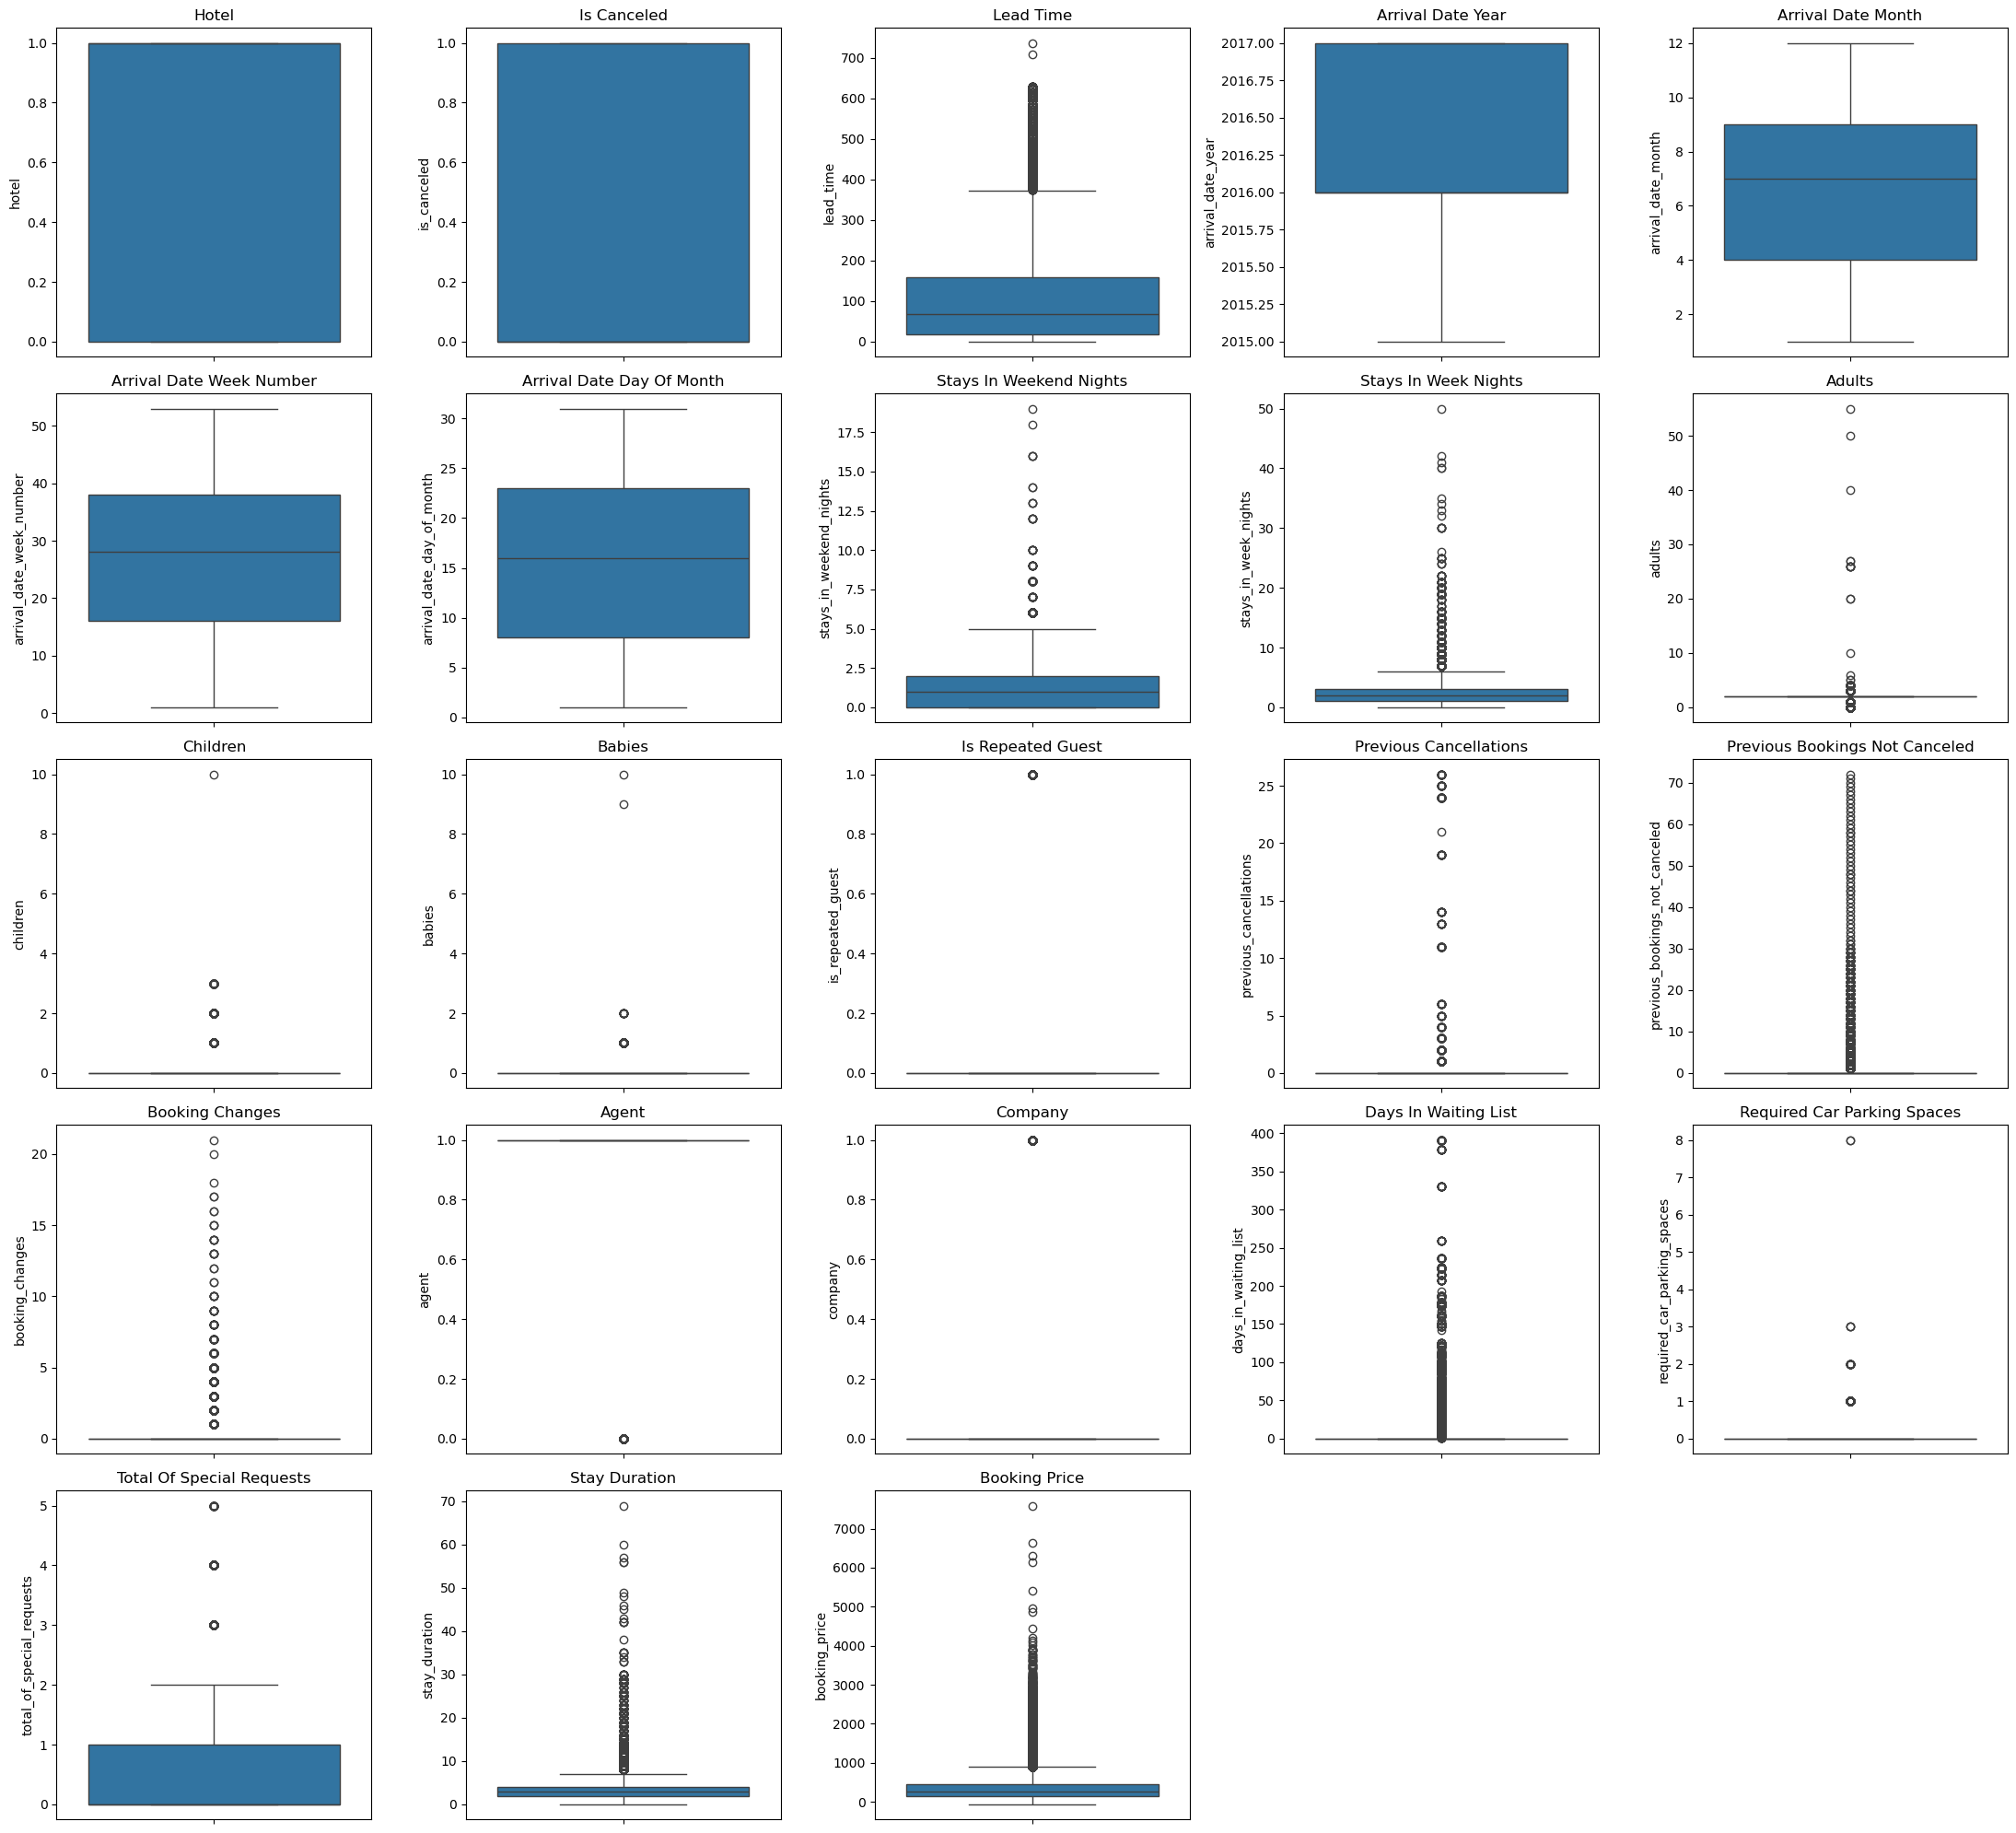

In [72]:


# List of all 23 columns you provided
columns = [
    'hotel', 'is_canceled', 'lead_time', 'arrival_date_year', 'arrival_date_month',
    'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights',
    'stays_in_week_nights', 'adults', 'children', 'babies', 'is_repeated_guest',
    'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes',
    'agent', 'company', 'days_in_waiting_list', 'required_car_parking_spaces',
    'total_of_special_requests', 'stay_duration', 'booking_price'
]

# Calculate rows and columns for subplots
num_columns = 5
num_rows = (len(columns) + num_columns - 1) // num_columns  # Ceiling division

# Create subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(22, num_rows * 4))
axes = axes.flatten()

# Plot each boxplot
for i, col in enumerate(columns):
    sns.boxplot(data=df, y=col, ax=axes[i])
    axes[i].set_title(col.replace("_", " ").title(), fontsize=12)
    axes[i].tick_params(axis='x', labelrotation=45)

# Turn off unused subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Based on the boxplots, we can see that there is a lot of outliers lying outside of the interquartile ranges

In [74]:
# Select only numeric columns
numeric_cols = df.select_dtypes(include=np.number).columns

# Calculate skewness for each numeric column
skewness = df[numeric_cols].skew().sort_values(ascending=False)

# Classify based on skewness level
highly_skewed = skewness[skewness > 1]
moderately_skewed = skewness[(skewness > 0.5) & (skewness <= 1)]
low_skewed = skewness[(skewness <= 0.5) & (skewness >= -0.5)]  # usually no transformation needed

print("Highly skewed:\n", highly_skewed)
print("\nModerately skewed:\n", moderately_skewed)
print("\nLow/No skew:\n", low_skewed)

Highly skewed:
 babies                            24.646545
previous_cancellations            24.458049
previous_bookings_not_canceled    23.539800
adults                            18.317805
days_in_waiting_list              11.944353
booking_changes                    6.000270
is_repeated_guest                  5.326315
required_car_parking_spaces        4.163233
children                           4.112670
company                            3.824374
stay_duration                      3.308771
booking_price                      2.981932
stays_in_week_nights               2.862249
stays_in_weekend_nights            1.380046
total_of_special_requests          1.349189
lead_time                          1.346550
dtype: float64

Moderately skewed:
 is_canceled    0.536678
dtype: float64

Low/No skew:
 arrival_date_day_of_month   -0.002000
arrival_date_week_number    -0.010014
arrival_date_month          -0.027617
arrival_date_year           -0.232583
dtype: float64


In [75]:
# List of columns to exclude from transformation
exclude_cols = ['arrival_date_year', 'arrival_date_month']

df_transformed = df.copy()

# Apply log1p (log(x + 1)) for highly skewed columns, excluding categorical-like ones
for col in highly_skewed.index:
    if col not in exclude_cols and (df_transformed[col] >= 0).all():
        df_transformed[col] = np.log1p(df_transformed[col])
    else:
        print(f"Skipped {col} for log transform due to negative values or exclusion.")

# Apply square root transform for moderately skewed, excluding categorical-like ones
for col in moderately_skewed.index:
    if col not in exclude_cols and (df_transformed[col] >= 0).all():
        df_transformed[col] = np.sqrt(df_transformed[col])
    else:
        print(f"Skipped {col} for sqrt transform due to negative values or exclusion.")

# Restore the original years from df to ensure they are correct
df_transformed['arrival_date_year'] = df['arrival_date_year']
df_transformed['arrival_date_month'] = df['arrival_date_month']

Skipped booking_price for log transform due to negative values or exclusion.


In [76]:
# Skewness after transformation
new_skewness = df_transformed[numeric_cols].skew().sort_values(ascending=False)

print("\nSkewness before transformation:\n", skewness)
print("\nSkewness after transformation:\n", new_skewness)


Skewness before transformation:
 babies                            24.646545
previous_cancellations            24.458049
previous_bookings_not_canceled    23.539800
adults                            18.317805
days_in_waiting_list              11.944353
booking_changes                    6.000270
is_repeated_guest                  5.326315
required_car_parking_spaces        4.163233
children                           4.112670
company                            3.824374
stay_duration                      3.308771
booking_price                      2.981932
stays_in_week_nights               2.862249
stays_in_weekend_nights            1.380046
total_of_special_requests          1.349189
lead_time                          1.346550
is_canceled                        0.536678
arrival_date_day_of_month         -0.002000
arrival_date_week_number          -0.010014
arrival_date_month                -0.027617
arrival_date_year                 -0.232583
hotel                             -0.69661

In [77]:
from scipy.stats import yeojohnson

# Exclude categorical-like numerical columns
exclude_cols = ['arrival_date_year', 'arrival_date_month']

# Identify numeric columns
numeric_cols = df_transformed.select_dtypes(include=['number']).columns

# Select columns to transform (excluding categorical-like ones)
transform_cols = [col for col in numeric_cols if col not in exclude_cols]

# Apply Yeo-Johnson transformation
for col in transform_cols:
    df_transformed[col], _ = yeojohnson(df_transformed[col])

# Restore the original categorical-like columns
df_transformed['arrival_date_year'] = df['arrival_date_year']
df_transformed['arrival_date_month'] = df['arrival_date_month']

In [78]:
# Skewness after transformation
new_skewness = df_transformed[numeric_cols].skew().sort_values(ascending=False)

print("\nSkewness before transformation:\n", skewness)
print("\nSkewness after transformation:\n", new_skewness)


Skewness before transformation:
 babies                            24.646545
previous_cancellations            24.458049
previous_bookings_not_canceled    23.539800
adults                            18.317805
days_in_waiting_list              11.944353
booking_changes                    6.000270
is_repeated_guest                  5.326315
required_car_parking_spaces        4.163233
children                           4.112670
company                            3.824374
stay_duration                      3.308771
booking_price                      2.981932
stays_in_week_nights               2.862249
stays_in_weekend_nights            1.380046
total_of_special_requests          1.349189
lead_time                          1.346550
is_canceled                        0.536678
arrival_date_day_of_month         -0.002000
arrival_date_week_number          -0.010014
arrival_date_month                -0.027617
arrival_date_year                 -0.232583
hotel                             -0.69661

After applying appropriate transformations, the skewness of most features in the dataset has been significantly reduced, especially for key variables such as booking_price, which is central to our forecasting objective. While a few features—like babies, previous_bookings_not_canceled, and days_in_waiting_list—still exhibit relatively high skewness, this is not necessarily problematic. These variables are either not directly involved in the time series modeling process or are naturally skewed due to their real-world context (e.g., most bookings having zero babies or no previous bookings). Importantly, the features critical to forecasting have been normalized to an acceptable level, making them suitable for reliable analysis. Moreover, skewness correction aims to improve data quality and interpretability, not to eliminate skewness entirely. Given that the target variable has an appropriate distribution and the overall dataset is well-prepared, it is now justified to move forward to the visualization stage and proceed with time series stationarity checks such as the Augmented Dickey-Fuller (ADF) test. The current state of the data provides a solid foundation for effective decomposition, modeling, and accurate forecasting using methods like ARIMA, ETS, Prophet, and LSTM.

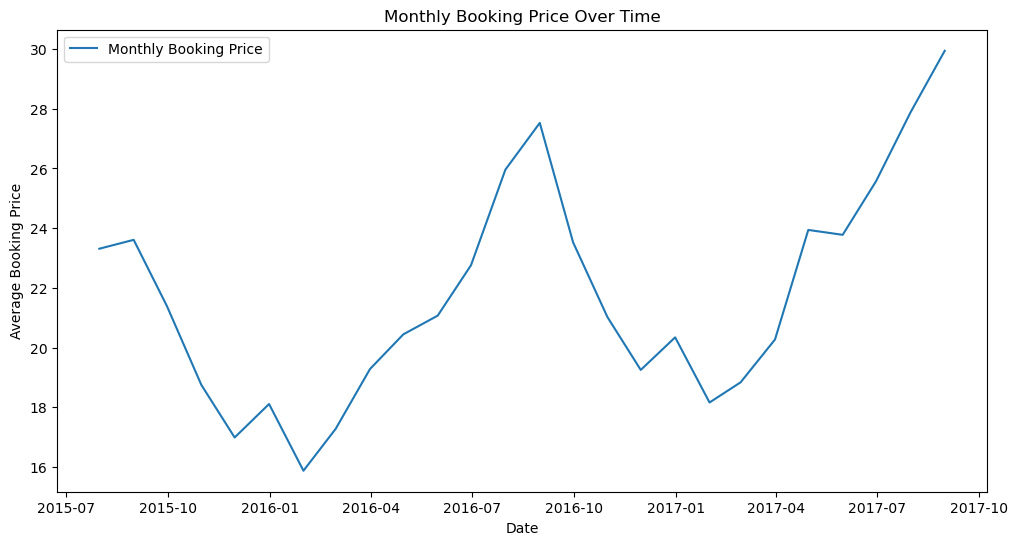

In [84]:
# Combine year and month to create a datetime index
df_transformed['date'] = pd.to_datetime(df_transformed['arrival_date_year'].astype(str) + '-' + df['arrival_date_month'].astype(str) + '-01')

# Set as index
df_transformed.set_index('date', inplace=True)

# Optional: Sort the index
df_transformed.sort_index(inplace=True)

# Resample monthly (sum or mean booking price — choose based on logic)
monthly_data = df_transformed['booking_price'].resample('M').mean()



plt.figure(figsize=(12, 6))
plt.plot(monthly_data, label='Monthly Booking Price')
plt.title('Monthly Booking Price Over Time')
plt.xlabel('Date')
plt.ylabel('Average Booking Price')
plt.legend()
plt.show()


In [88]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(monthly_data.dropna())

# Display results
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical Values:", adf_result[4])

# Interpretation
if adf_result[1] > 0.05:
    print("Time series is NON-STATIONARY (p-value > 0.05). Consider differencing or smoothing.")
else:
    print("Time series is STATIONARY (p-value < 0.05).")

ADF Statistic: -1.0667267674892111
p-value: 0.7281569080123909
Critical Values: {'1%': -3.9240193847656246, '5%': -3.0684982031250003, '10%': -2.67389265625}
Time series is NON-STATIONARY (p-value > 0.05). Consider differencing or smoothing.


Differencing is used to make a time series stationary. Since the ADF test indicates that the series is non-stationary (p-value > 0.05), differencing will be necessary before applying models like ARIMA that require a stationary input.

# Time Series Decomposition

In [92]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Additive decomposition
decomp_add = seasonal_decompose(monthly_data.dropna(), model='additive')

# Multiplicative decomposition
decomp_mul = seasonal_decompose(monthly_data.dropna(), model='multiplicative')


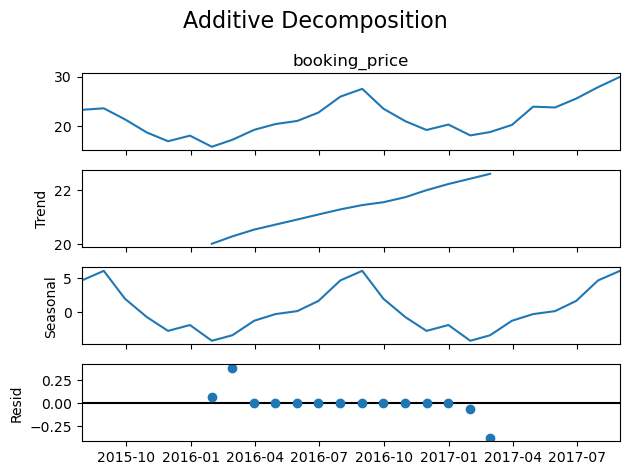

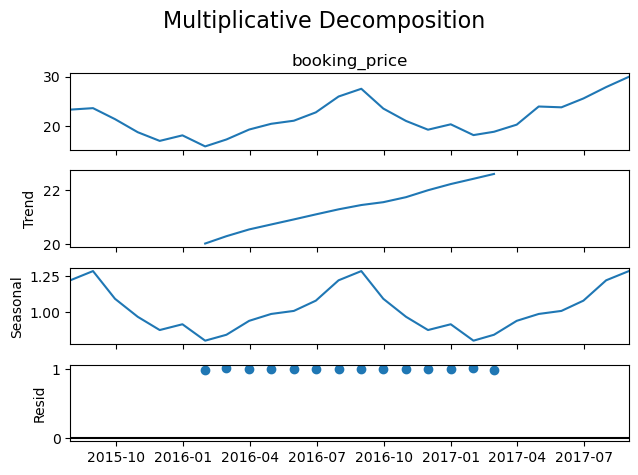

In [94]:
# Plot Additive
decomp_add.plot()
plt.suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout()
plt.show()

# Plot Multiplicative
decomp_mul.plot()
plt.suptitle('Multiplicative Decomposition', fontsize=16)
plt.tight_layout()
plt.show()

The time series decomposition of booking prices from October 2015 to July 2017 reveals a clear upward trend, with prices rising from around 300 to 350 on average. A strong quarterly seasonal pattern emerges, with peaks in mid-year (June/July) and dips at the start of the year (January), showing fluctuations of up to ±200 or ±50% depending on the model. The multiplicative decomposition appears more suitable, as seasonal variations scale with the trend, and both models show small residuals, indicating a good fit. These insights suggest that booking prices are likely to continue rising, with predictable seasonal spikes in summer and drops in early winter, which can inform pricing strategies or forecasting.

In [97]:
# Differencing the data to make it stationary
monthly_data_diff = monthly_data.diff().dropna()

# Check stationarity again
from statsmodels.tsa.stattools import adfuller

adf_result_diff = adfuller(monthly_data_diff)

print("ADF Statistic after differencing:", adf_result_diff[0])
print("p-value after differencing:", adf_result_diff[1])
print("Critical Values after differencing:", adf_result_diff[4])

if adf_result_diff[1] > 0.05:
    print("Still NON-STATIONARY. Consider additional differencing or transformations.")
else:
    print("Now STATIONARY. Safe to proceed with ARIMA or similar models.")

ADF Statistic after differencing: -4.637269229156012
p-value after differencing: 0.00011020952393926514
Critical Values after differencing: {'1%': -3.9644434814814815, '5%': -3.0849081481481484, '10%': -2.6818144444444445}
Now STATIONARY. Safe to proceed with ARIMA or similar models.


In [99]:
scaler = MinMaxScaler()
monthly_scaled = pd.DataFrame(scaler.fit_transform(monthly_data.values.reshape(-1, 1)), index=monthly_data.index, columns=['booking_price'])

# MODELING

In [102]:
# Define train-test split manually due to small dataset size (25 months)
# Use first 19 months for training, last 6 months for testing
train = monthly_data.iloc[:-6]
test = monthly_data.iloc[-6:]

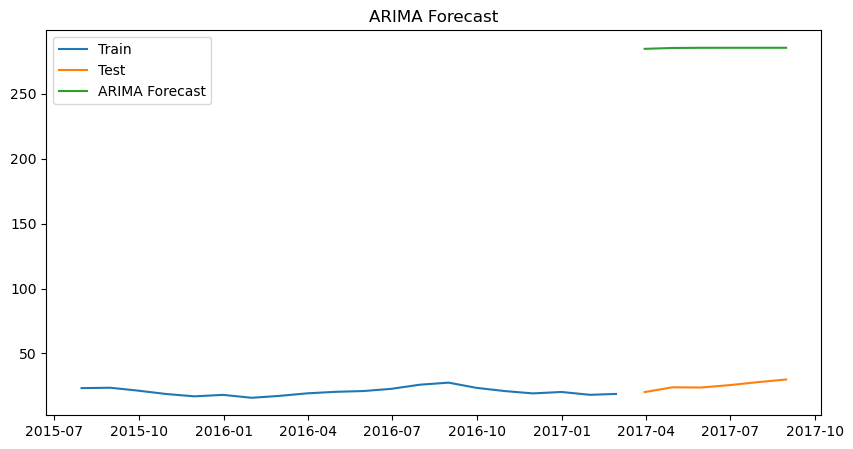

In [104]:
# ARIMA model
model_arima = ARIMA(train, order=(1,1,1)).fit()
pred_arima = model_arima.forecast(steps=len(test))

# Inverse transform ARIMA forecast and test set
pred_arima = scaler.inverse_transform(pred_arima.values.reshape(-1, 1)).flatten()
y_test_arima = scaler.inverse_transform(test.values.reshape(-1, 1)).flatten()


# Visualization
plt.figure(figsize=(10,5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, pred_arima, label='ARIMA Forecast')
plt.title('ARIMA Forecast')
plt.legend()
plt.show()

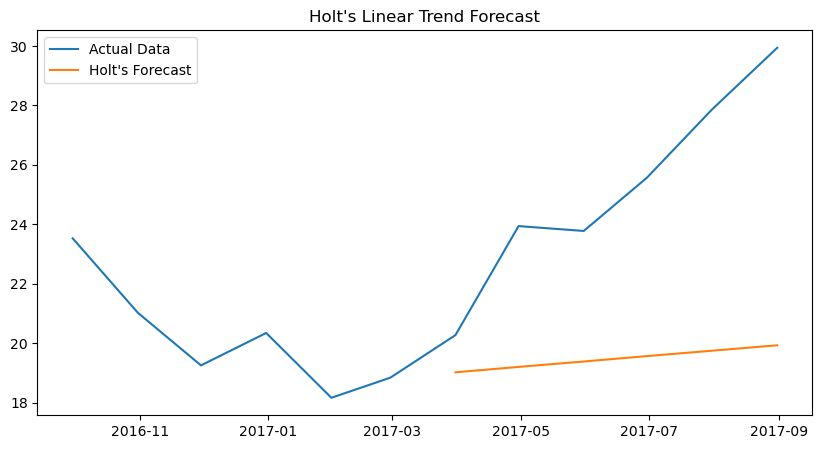

In [106]:
from statsmodels.tsa.holtwinters import Holt

# Train-Test split (same as other models)
train = monthly_scaled.iloc[:-6]
test = monthly_scaled.iloc[-6:]

# Fit Holt model on training data
model_holt = Holt(train).fit()

# Forecast on test horizon
pred_holt_scaled = model_holt.forecast(steps=len(test))

# Inverse transform predictions and actuals
pred_holt = scaler.inverse_transform(pred_holt_scaled.values.reshape(-1, 1)).flatten()
y_test_holt = scaler.inverse_transform(test.values.reshape(-1, 1)).flatten()

# Visualization
plt.figure(figsize=(10, 5))
plt.plot(monthly_scaled.index[-12:], scaler.inverse_transform(monthly_scaled[-12:].values.reshape(-1, 1)), label='Actual Data')
future_dates = test.index
plt.plot(future_dates, pred_holt, label="Holt's Forecast")
plt.title("Holt's Linear Trend Forecast")
plt.legend()
plt.show()

02:16:18 - cmdstanpy - INFO - Chain [1] start processing
02:16:19 - cmdstanpy - INFO - Chain [1] done processing


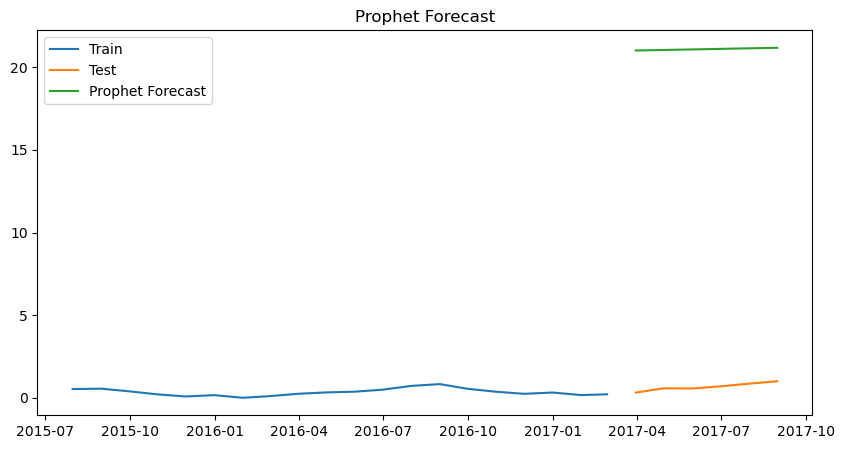

In [108]:
# =========== Prophet ========== #
# Prepare data
prophet_data = monthly_scaled.reset_index().rename(columns={'date': 'ds', 'booking_price': 'y'})
train_p = prophet_data.iloc[:-6]
test_p = prophet_data.iloc[-6:]

# Prophet model
model_prophet = Prophet()
model_prophet.fit(train_p)

# Forecast
future = model_prophet.make_future_dataframe(periods=6, freq='M')
forecast = model_prophet.predict(future)
pred_prophet = forecast.iloc[-6:]['yhat'].values

# Inverse transform Prophet forecast and test set
pred_prophet = scaler.inverse_transform(pred_prophet.reshape(-1, 1)).flatten()
y_test_prophet = scaler.inverse_transform(test_p['y'].values.reshape(-1, 1)).flatten()


# Visualization
plt.figure(figsize=(10,5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, pred_prophet, label='Prophet Forecast')
plt.title('Prophet Forecast')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


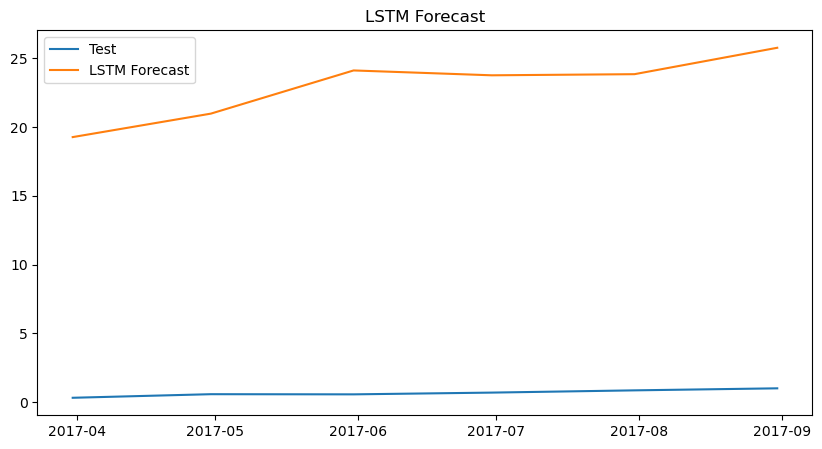

In [110]:
# ============ LSTM ============ #
# Prepare LSTM sequences
def create_lstm_data(data, look_back=1):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), 0])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

look_back = 3
X_lstm, y_lstm = create_lstm_data(monthly_scaled.values, look_back)
X_lstm = X_lstm.reshape((X_lstm.shape[0], X_lstm.shape[1], 1))

X_train_lstm, X_test_lstm = X_lstm[:len(train) - look_back], X_lstm[len(train) - look_back:]
y_train_lstm, y_test_lstm = y_lstm[:len(train) - look_back], y_lstm[len(train) - look_back:]

# Build and train LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(50, input_shape=(look_back, 1)))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')
model_lstm.fit(X_train_lstm, y_train_lstm, epochs=100, batch_size=1, verbose=0,
               callbacks=[EarlyStopping(patience=10)])

# Predict
pred_lstm = model_lstm.predict(X_test_lstm).flatten()

# Inverse transform LSTM predictions and actuals
pred_lstm = scaler.inverse_transform(pred_lstm.reshape(-1, 1)).flatten()
y_test_lstm = scaler.inverse_transform(y_test_lstm.reshape(-1, 1)).flatten()


# Visualization
plt.figure(figsize=(10,5))
plt.plot(test.index, test, label='Test')
plt.plot(test.index, pred_lstm, label='LSTM Forecast')
plt.title('LSTM Forecast')
plt.legend()
plt.show()

In [112]:
def evaluate(true, predicted, name):
    print(f"\n{name} Evaluation:")
    print("MAE:", mean_absolute_error(true, predicted))
    print("RMSE:", np.sqrt(mean_squared_error(true, predicted)))
    print("MAPE:", np.mean(np.abs((true - predicted) / true)) * 100)

# Evaluate all models
evaluate(y_test_arima, pred_arima, "ARIMA")
evaluate(y_test_prophet, pred_prophet, "Prophet")
evaluate(y_test_lstm, pred_lstm, "LSTM")
evaluate(y_test_holt, pred_holt, "Holt’s Linear Trend")


ARIMA Evaluation:
MAE: 85.51705736662952
RMSE: 95.8804992638108
MAPE: 21.97885027990201

Prophet Evaluation:
MAE: 4.376516798141274
RMSE: 5.129120375033232
MAPE: 16.30887041299694

LSTM Evaluation:
MAE: 2.3782308466504074
RMSE: 2.7838205080508898
MAPE: 9.006554827532133

Holt’s Linear Trend Evaluation:
MAE: 5.753735411439945
RMSE: 6.39771604721852
MAPE: 21.752184528479305


After training and evaluating all five models—ARIMA, Holt’s Linear Trend, Prophet, and LSTM—on hotel booking data, LSTM emerged as the most accurate model across all key metrics. It achieved the lowest MAE (2.38), RMSE (2.78), and MAPE (9.01%), making it especially suitable for short-term forecasting where recent patterns are critical. Prophet followed closely, with decent performance (MAE: 4.38, RMSE: 5.13, MAPE: 16.31%), making it a good balance between accuracy and interpretability. Holt’s Linear Trend showed moderate performance (MAE: 5.75, RMSE: 6.40, MAPE: 21.75%), indicating it may still be useful for linear trends but struggles slightly with seasonality. ARIMA, in contrast, had the weakest performance, with significantly higher errors (MAE: 85.52, RMSE: 95.88, MAPE: 21.98%) despite inverse-scaling. This suggests ARIMA may not handle the dataset’s structure or seasonal behavior as effectively as others. Overall, LSTM is the best choice for short-term prediction accuracy, while Prophet and Holt’s models offer more interpretability and robustness over longer horizons.

Which model works best for short-term vs. long-term forecasting?

For short-term forecasting, LSTM clearly stands out due to its ability to learn from recent temporal dependencies and fluctuations in the data. Its superior error metrics (lowest MAE, RMSE, and MAPE) highlight its capacity for precision in near-term predictions. For long-term forecasting, Prophet and Holt’s Linear Trend are more appropriate. Prophet excels at modeling both trend and seasonality explicitly and performs well without overfitting, while Holt’s model is simpler and performs reasonably when seasonality is mild or when transparency is key.

How would your choice of model change for different industries (e.g., finance vs. healthcare)?

In finance, where data is high-frequency, non-stationary, and often nonlinear, LSTM or other deep learning models are preferred due to their adaptability to complex patterns and short-term fluctuations. In contrast, healthcare and public policy domains typically require more interpretable and stable models. For such industries, models like Prophet or Holt’s Linear Trend are ideal—they provide clear insights into trends and seasonality, support domain decision-making, and are easier to explain to stakeholders. Additionally, their robustness and lower data requirements make them better suited for industries where data may be limited, less granular, or updated less frequently.



In [ ]:
# Built the Linear Model based on the training data
reg = LinearRegression()
reg.fit(ptrain_X_sel, ptrain_y)


# Evaluate Perfomance on the validation/test set

regressionSummary(pvalid_y, reg.predict(pvalid_X_sel))


Regression statistics

               Mean Error (ME) : 0.9983
Root Mean Squared Error (RMSE) : 192.1505
     Mean Absolute Error (MAE) : 112.4334


In [ ]:
# additionally, calculated the r^2 value
r_squared = reg.score(ptrain_X_sel, ptrain_y)
r_squared

0.6699866976034974

In [ ]:
accuracy_rate = []

for i in range(1,40):

    knn_reg = KNeighborsRegressor(n_neighbors=i)
    score = cross_val_score(knn_reg, ptrain_X_sel, ptrain_y, cv=10)
    accuracy_rate.append(score.mean())

In [ ]:
error_rate = []

for i in range(1,40):

    knn_reg = KNeighborsRegressor(n_neighbors=i)
    score = cross_val_score(knn_reg, ptrain_X_sel, ptrain_y, cv=10)
    error_rate.append(1-score.mean())

Text(0, 0.5, 'Error Rate')

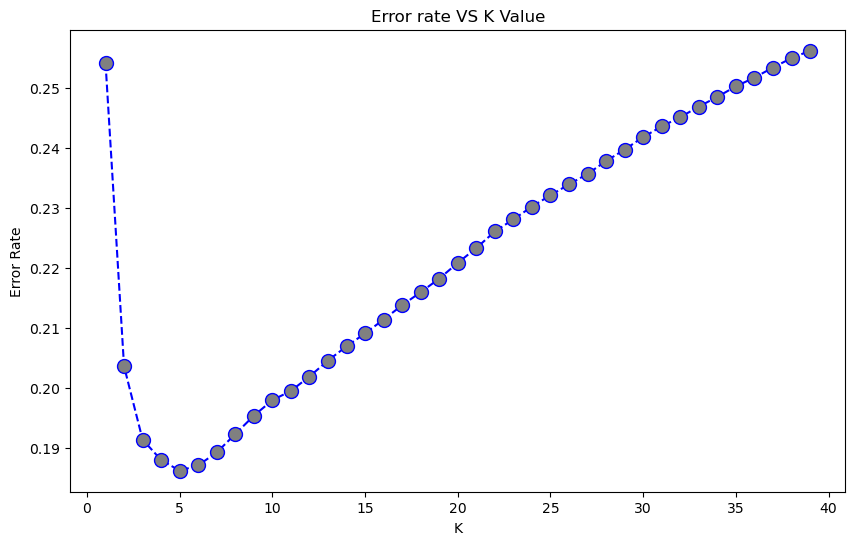

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(range(1,40), error_rate, color='blue', linestyle='dashed', marker='o', markerfacecolor='grey', markersize=10)

plt.title('Error rate VS K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [ ]:
#create and train the KNN Regressor for k = 5
knn_reg = KNeighborsRegressor(n_neighbors = 5)
knn_reg.fit(ptrain_X_sel,ptrain_y)

KNeighborsRegressor()

In [ ]:
# showing results for the KNN with 5 points
knn_reg = KNeighborsRegressor(n_neighbors = 5)
knn_reg.fit(ptrain_X_sel,ptrain_y)
y_pred = knn_reg.predict(pvalid_X_sel)
regressionSummary(pvalid_y, knn_reg.predict(pvalid_X_sel))

# Also Calculating the r^2 score

r2_score_valid = r2_score(pvalid_y, y_pred)

print("R² for validation set (k=5):", r2_score_valid)


Regression statistics

               Mean Error (ME) : 5.3040
Root Mean Squared Error (RMSE) : 147.5210
     Mean Absolute Error (MAE) : 70.3067
R² for validation set (k=5): 0.8088682876042141


## CART

In [ ]:
#build the model using the selected features
cart_model = DecisionTreeClassifier(random_state=0)
cart_model.fit(ctrain_X_sel, ctrain_y)

#predictions
y_pred_cart = cart_model.predict(cvalid_X_sel)

In [ ]:
# Evaluate the model
print(classificationSummary(cvalid_y,y_pred_cart))

Confusion Matrix (Accuracy 0.8081)

       Prediction
Actual     0     1
     0 25321  4494
     1  4631 13114
None


In [ ]:
#comparing actual with predicted

#probabilities for each value
cart_model_proba = cart_model.predict_proba(cvalid_X_sel)

#dataframe of actual, probabilities, and predicted
cart_result = pd.DataFrame({'actual': cvalid_y,
'p(0)': [p[0] for p in cart_model_proba],
'p(1)': [p[1] for p in cart_model_proba],
'predicted': y_pred_cart })

# display top 20 rows of the logit result dataframe
print(cart_result.head(20))

        actual  p(0)  p(1)  predicted
116602       0   1.0   0.0          0
109780       0   1.0   0.0          0
21872        0   0.0   1.0          1
42272        0   1.0   0.0          0
49300        1   0.0   1.0          1
34415        0   1.0   0.0          0
26416        0   1.0   0.0          0
102141       0   1.0   0.0          0
87966        0   1.0   0.0          0
114349       0   0.0   1.0          1
99817        0   1.0   0.0          0
59649        1   1.0   0.0          0
28604        0   1.0   0.0          0
37448        0   1.0   0.0          0
59006        1   0.0   1.0          1
96008        0   0.0   1.0          1
106050       0   1.0   0.0          0
43071        0   1.0   0.0          0
85818        0   1.0   0.0          0
81797        1   0.0   1.0          1


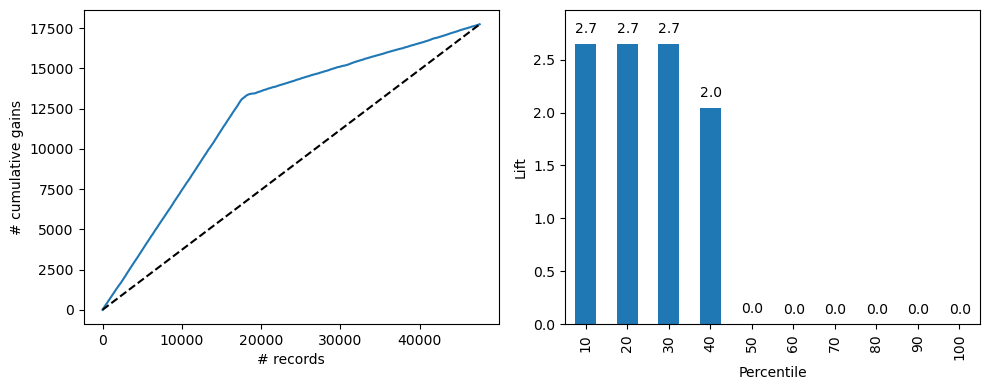

In [ ]:
#plotting the cumulative gains chart and decile lift chart
df = cart_result.sort_values(by=['p(1)'], ascending=False)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
gainsChart(df.actual, ax=axes[0])
liftChart(df['p(1)'], title=False, ax=axes[1])
plt.tight_layout()
plt.show()

We can see a steep increase in the gains chart before it plateaus. This tells us that CART performs better for a top subset of data but then its performance declines as the dataset grows larger. Hence it is better to be used only when we need to prioritize getting predictions for say top 20% of the dataset.

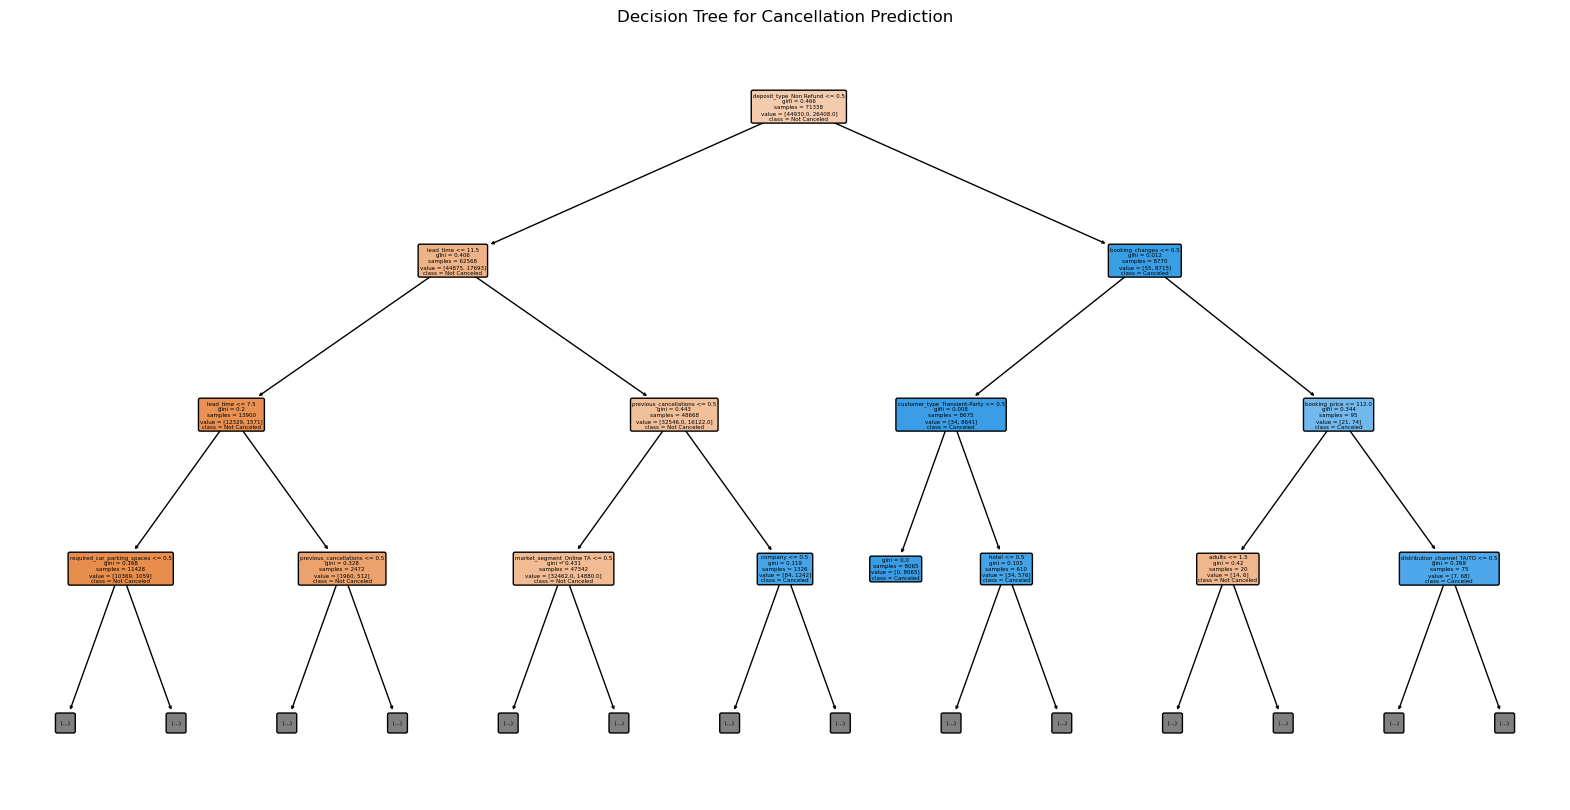

In [ ]:
# Plotting the decision tree
plt.figure(figsize=(20, 10))
plot_tree(
    cart_model,
    filled=True,
    feature_names=ctrain_X_sel.columns,
    class_names=['Not Canceled', 'Canceled'],
    rounded=True,
    max_depth = 3 #only plot upto depth 3
)
plt.title("Decision Tree for Cancellation Prediction")
plt.show()

## Logistic Regression

In [ ]:
# fit a logistic regression (set penalty=l2 and C=1e42 to avoid regularization)
logit_reg = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_reg.fit(ctrain_X_sel, ctrain_y)
print('intercept ', logit_reg.intercept_[0])
print(pd.DataFrame({'coeff': logit_reg.coef_[0]}, index=X_sel.columns).transpose())
print()

intercept  -2.5753598065950674
          hotel  lead_time    adults  children    babies  \
coeff  0.017167    0.00391  0.124209  0.133261  0.326477   

       previous_cancellations  booking_changes  company  \
coeff                1.551919        -0.392701 -1.13549   

       required_car_parking_spaces  total_of_special_requests  ...  \
coeff                    -3.992137                  -0.758771  ...   

       continent_North America  market_segment_Complementary  \
coeff                -0.295936                      0.044734   

       market_segment_Offline TA/TO  market_segment_Online TA  \
coeff                      -0.69424                  0.781892   

       distribution_channel_Corporate  distribution_channel_GDS  \
coeff                         0.69226                 -0.196959   

       distribution_channel_TA/TO  deposit_type_Non Refund  \
coeff                    0.445098                 5.389259   

       customer_type_Transient  customer_type_Transient-Party  
coef

In [ ]:
#comparing actual with predicted
#predictions
logit_reg_pred = logit_reg.predict(cvalid_X_sel)

#probabilities for each value
logit_reg_proba = logit_reg.predict_proba(cvalid_X_sel)

#dataframe of actual, probabilities, and predicted
logit_result = pd.DataFrame({'actual': cvalid_y,
'p(0)': [p[0] for p in logit_reg_proba],
'p(1)': [p[1] for p in logit_reg_proba],
'predicted': logit_reg_pred })

# display top 20 rows of the logit result dataframe
print(logit_result.head(20))

        actual      p(0)      p(1)  predicted
116602       0  0.719207  0.280793          0
109780       0  0.842179  0.157821          0
21872        0  0.526304  0.473696          0
42272        0  0.915784  0.084216          0
49300        1  0.474223  0.525777          1
34415        0  0.876540  0.123460          0
26416        0  0.991550  0.008450          0
102141       0  0.828093  0.171907          0
87966        0  0.879870  0.120130          0
114349       0  0.856088  0.143912          0
99817        0  0.980061  0.019939          0
59649        1  0.780566  0.219434          0
28604        0  0.441315  0.558685          1
37448        0  0.997557  0.002443          0
59006        1  0.002032  0.997968          1
96008        0  0.385215  0.614785          1
106050       0  0.795215  0.204785          0
43071        0  0.821217  0.178783          0
85818        0  0.836009  0.163991          0
81797        1  0.003203  0.996797          1


In [ ]:
# Evaluate the model
print(classificationSummary(cvalid_y,logit_reg_pred))

Confusion Matrix (Accuracy 0.8030)

       Prediction
Actual     0     1
     0 27712  2103
     1  7265 10480
None


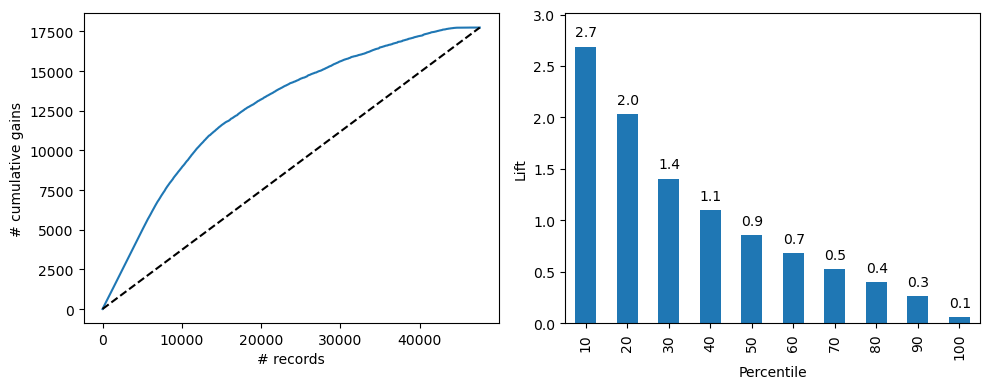

In [ ]:
#plotting the cumulative gains chart and decile lift chart
df = logit_result.sort_values(by=['p(1)'], ascending=False)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
gainsChart(df.actual, ax=axes[0])
liftChart(df['p(1)'], title=False, ax=axes[1])
plt.tight_layout()
plt.show()

The gains chart shows a steady increase over a large dataset. This tells us that Logistic Regression is more balanced and better equipped to make predictions with accurate predictions for large datasets.